# Grupowanie win pod względem ich podobieństwa
Jako przykład zastosowania algorytmu HDBSCAN* posłuży zbiór danych pochodzący z UCI Machine Learning Repository i dotyczy on jakości poszczególnych rodzajów wina. Cały zbiór danych podzielony jest na dwa pliki - dane dotyczące wina białego i czerwonego. Nazwa "Vinho Verde", dosłownie "*wino zielone*" określa różne rodzaje młodych win pochodzących z Portugalii. Odnosi się ona do młodości i świeżości wina, a nie do koloru, ponieważ tego typu trunek może być biały, czerwony, a niekiedy również różowy. Większość z tych win należy pić póki są świeże, a więc mają między 9 a 18 miesięcy. 

Wykorzystując zgromadzone dane zastosowany zostanie algorytm HDBSCAN* który pozwoli określić, które z rodzajów win są do siebie podobne. Zebrane dane są zanonimizowane, jednakże w rzeczywistym środowisku, mając etykiety każdego z trunków, można byłoby stworzyć silnik odpowiedni rekomendacyjny. Tego typu rozwiązanie pozwoliłoby zasugerować koneserowi, które butelki mogłyby go zainteresować, bazując na jego dotychczasowych preferencjach.  

Oba zbiory danych są zanonimizowane, dlatego też dostępne są tylko zmienne fizykochemiczne i sensoryczne, stąd też brak danych dotyczących rodzajów winogron, marki wina, ceny sprzedaży itp. Oba zbiory są zbalansowane pod względem półki cenowej, a więc dominują wina ze średniej półki cenowej, mniej jest tańszych i droższych butelek.  

Zbiór składa się z następujących zmiennych fizykochemicznych:

Input variables (based on physicochemical tests):
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
Output variable (based on sensory data):
12 - quality (score between 0 and 10)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Czytamy i łączymy oba zbiory danych 

In [2]:
data_raw_red_wine = pd.read_csv('./data/winequality-red.csv', sep=';')
data_raw_white_wine = pd.read_csv('./data/winequality-white.csv', sep=';')

data_red_wine = data_raw_red_wine.copy()
data_white_wine = data_raw_white_wine.copy()
data_wine = pd.concat([data_red_wine, data_white_wine], ignore_index=True) 
display(data_wine)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Należy sprawdzić, czy są jakieś missingi. Jeśli tak, to brakujące wartości należy usunąć lub w jakiś sposób uzupełnić (np. podając najbardziej popularną wartość). W tym przypadku nie mamy brakóœ danych.

In [3]:
data_wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [4]:
print(data_wine["fixed acidity"])

0        7.4
1        7.8
2        7.8
3       11.2
4        7.4
        ... 
6492     6.2
6493     6.6
6494     6.5
6495     5.5
6496     6.0
Name: fixed acidity, Length: 6497, dtype: float64


## Wizualizacja wyników


In [5]:
# PC = physicochemical 
pc_questions = {'PC1' : 'fixed acidity',
                 'PC2' : 'volatile acidity',
                 'PC3' : 'citric acid',
                 'PC4' : 'residual sugar',
                 'PC5' : 'chlorides',
                 'PC6' : 'free sulfur dioxide',
                 'PC7' : 'total sulfur dioxide',
                 'PC8' : 'density',
                 'PC9' : 'pH',
                 'PC10': 'I am quiet around strangers',
                 'PC11' : 'sulphates',
                 'PC12': 'alcohol'
                }

# Group Names and Columns
PC = [column for column in data_wine]
print(PC)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [6]:
display(pc_questions)

{'PC1': 'fixed acidity',
 'PC2': 'volatile acidity',
 'PC3': 'citric acid',
 'PC4': 'residual sugar',
 'PC5': 'chlorides',
 'PC6': 'free sulfur dioxide',
 'PC7': 'total sulfur dioxide',
 'PC8': 'density',
 'PC9': 'pH',
 'PC10': 'I am quiet around strangers',
 'PC11': 'sulphates',
 'PC12': 'alcohol'}

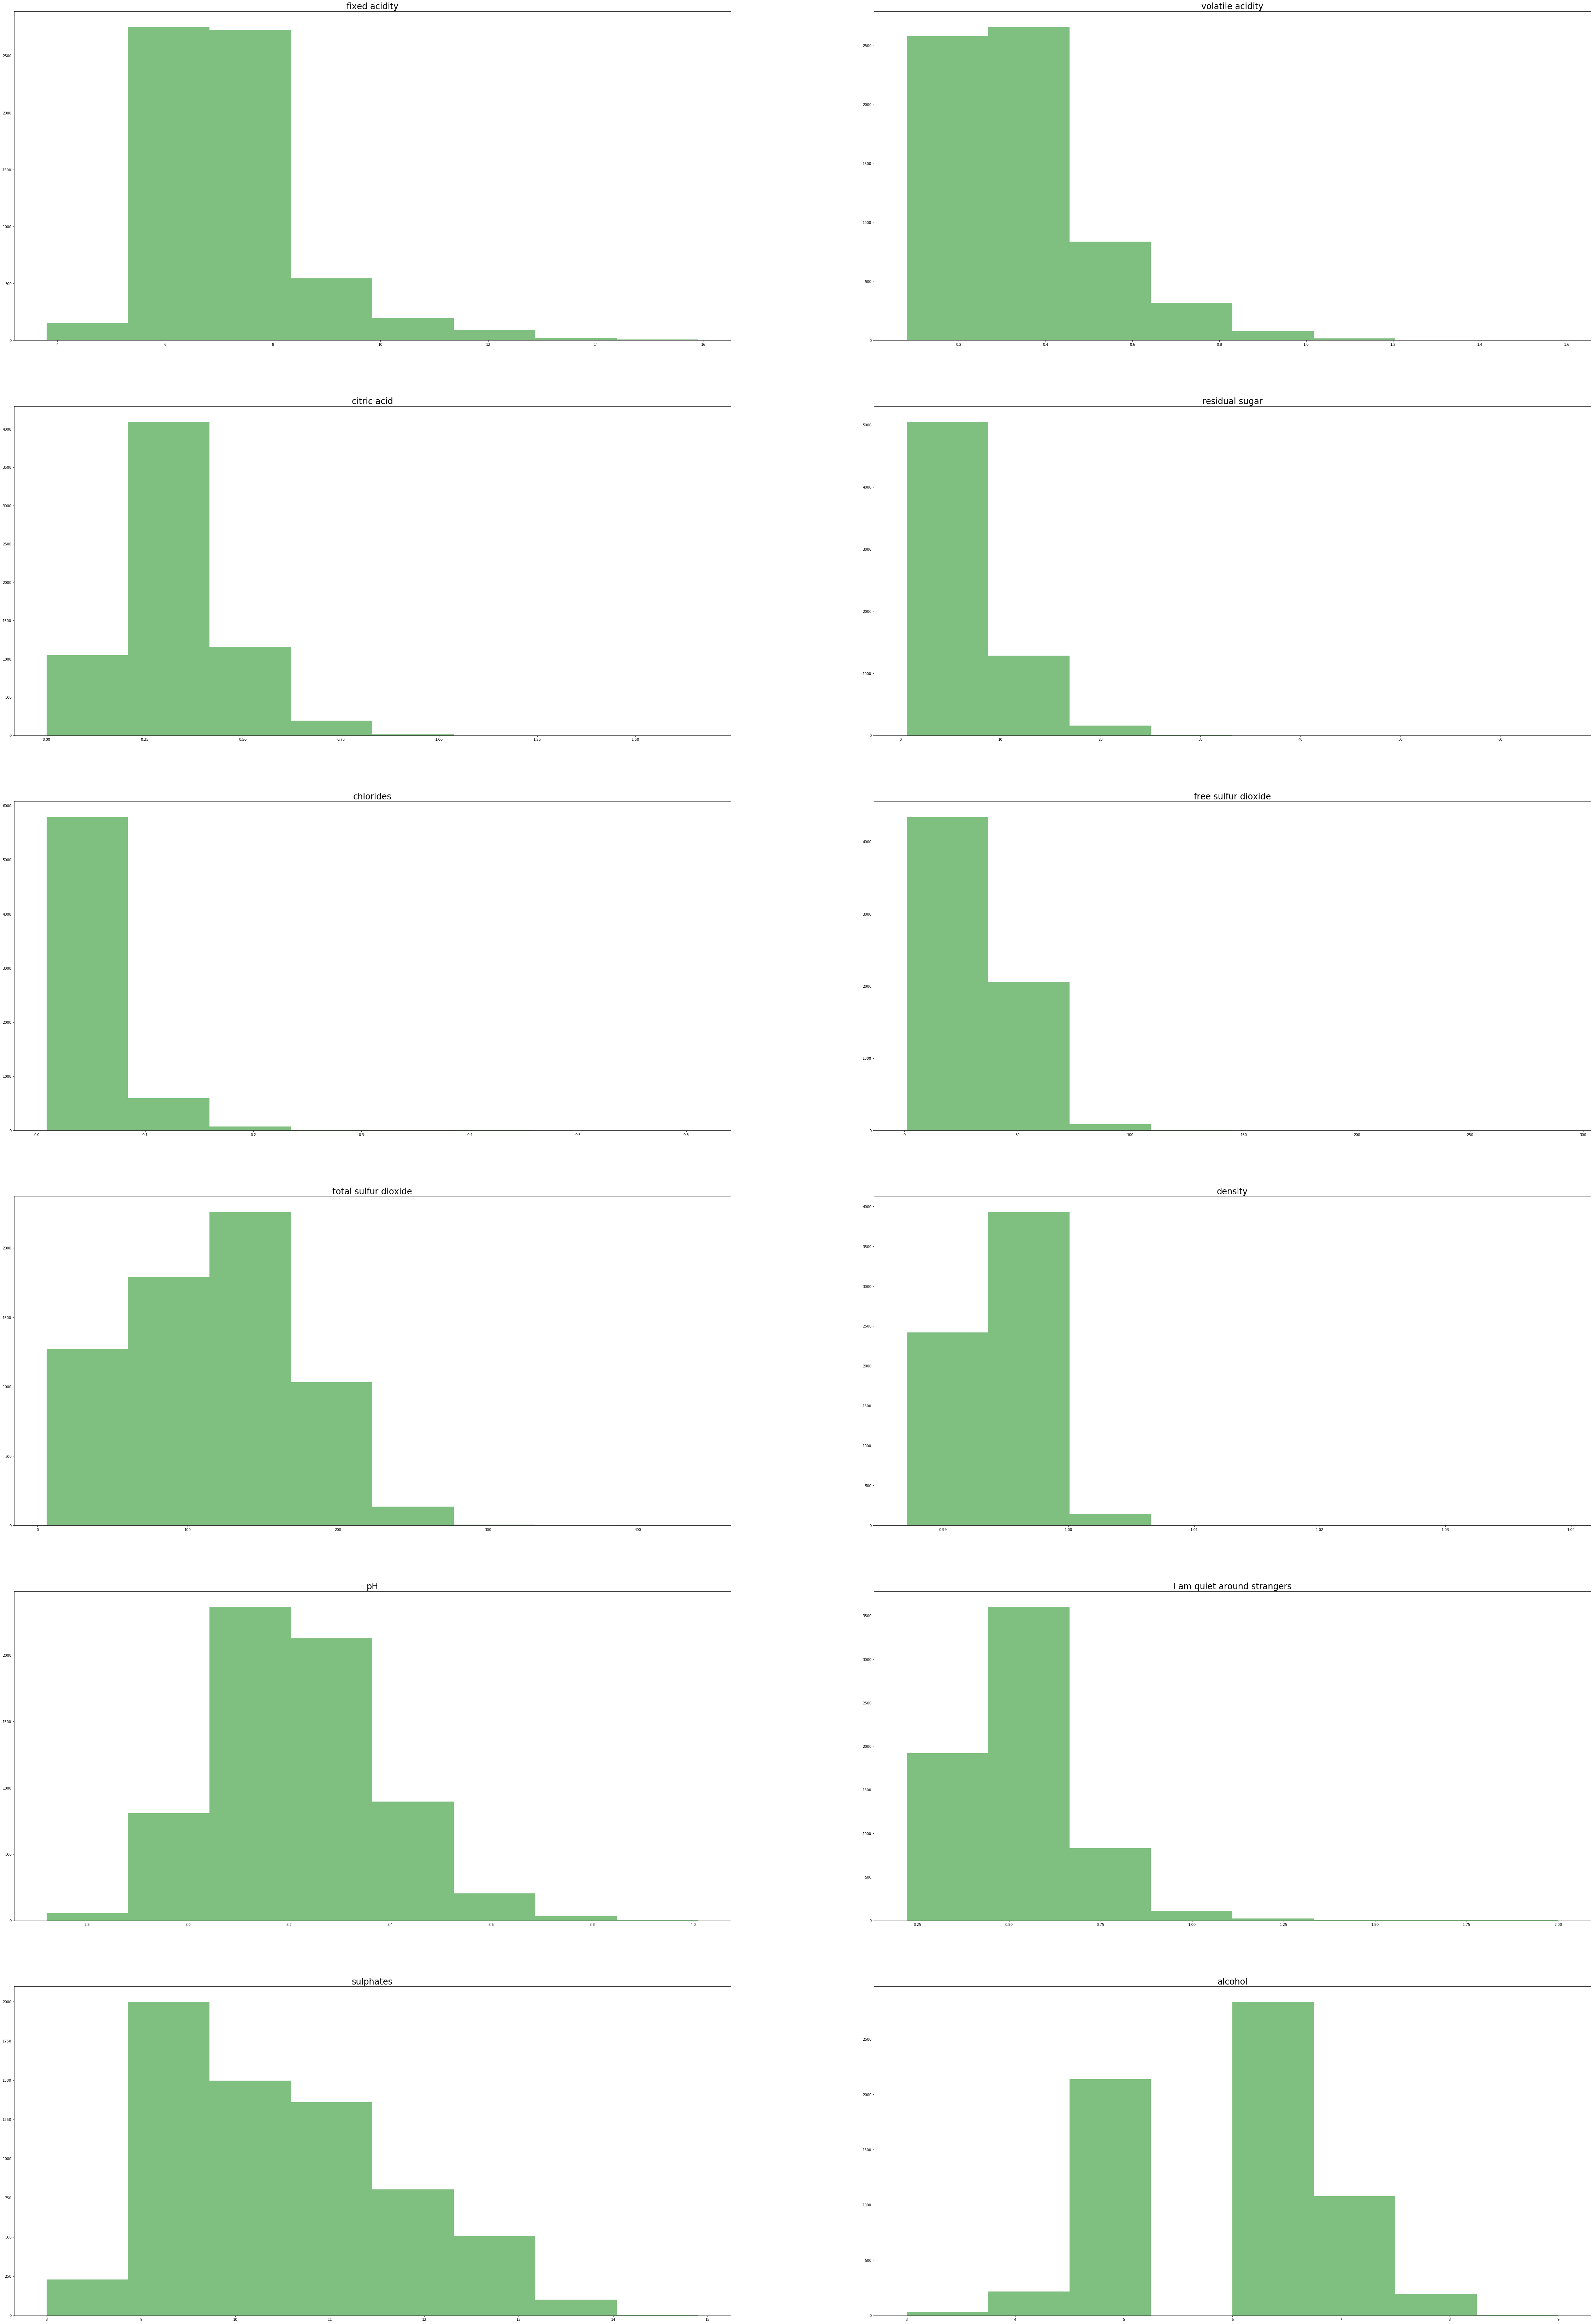

In [7]:
# Defining a function to visualize the questions and answers distribution

plt.figure(figsize=(80,120))
for i in range(1, 13):
    plt.subplot(6,2,i)
    plt.hist(data_wine[PC[i-1]], bins=8, color= 'green', alpha=.5)
    plt.title(pc_questions["PC"+str(i)], fontsize=24)

## HDBSCAN
Na początku importujemy bibliotekę HDBSCAN. Następnie tworzymy odpowidnią instancję klasy HDBSCAN. Podczas jej tworzenia użytkownik ma możliwośc podania następujących opcji: 
- **algorithm** - Okresla jaki algorytm zostanie użyty. hdbscan oferuje różne warianty w zależności od różnych danych. Domyślnie wybiera on najlepszą z dostepnych metod, jednakże można wymusić wykorzystanie konkretnej metody. Lista zawiera opcje best, generic, prims_kdtree, prims_balltree, boruvka_kdtree oraz boruvka_balltree.
- **allow_single_cluster** - Domyslnie HDBSCAN* nie zezwala na powstawanie jednoelementowych klastrów, jednakże można zezwolić na tego typu grupy. 
- **alpha** - parametr odpowiadający za salowanie odległości w algorytmie Robust Single Linkage (silnego klastrowania z pojedynczym łączeniem).
- **approx_min_span_tree** - Czy zaakceptować tylko przybliżone minimalne drzewo opinające. W przypadku niektórych algorytmów może to zapewnić znaczne przyspieszenie, ale uzyskane w ten sposób grupowanie może być nieznacznie niższej jakości. Jeśli jednak istotne jest uzyskanie dokładnego grupowania kosztem wydajności, można ustawić ten parametr na False. 
- **cluster_selection_epsilon** - Próg odległości. Klastry poniżej tej wartości zostaną scalone.
- **cluster_selection_method** - Metoda stosowana do wybierania klastrów ze skondensowanego drzewa. Celem jest znalezienie najbardziej trwałych klastrów bazując na przyroście masy prawdopodobieństwa. Alternatywnie można zamiast tego wybrać klastry patrąc na liście drzewa - zapewnia to najdrobniejsze i jednorodne skupiska. Dostępne są opcje *eom* oraz *leaf*.
- **core_dist_n_jobs** - liczba zrównoleglonych obliczeń w przypadku podstawowych obliczeń odległości (jeśli jest obsługiwana przez określony algorytm).
- **gen_min_span_tree** - Czy generować minimalne drzewo rozpinające, z uwzględnieniem odległości wzajemnej osiągalności do późniejszej analizy.
- **leaf_size** -W przypadku wykorzystania jednego z algorytmów drzewa przestrzennego (kdtree lub balltree), parametr ten stanowi liczbę punktów w węźle liścia drzewa. Nie zmienia to wynikowego klastrowania, ale może mieć wpływ na czas wykonywania algorytmu.
- **match_reference_implementation** - flaga ta umożliwia zgodność z implementacją referencyjną algorytmu, napisaną w Javie. 
- **memory** - Służy do buforowania danych wyjściowych obliczeń drzewa. Domyślnie buforowanie nie jest wykonywane.
- **metric** - Metryka używana podczas obliczania odległości między wystąpieniami w szyku elementów. 
- **min_cluster_size** - minimalny rozmiar klastra. Poniżej tej wartości ellementy uznawane są za szum i nie będą uwzględniane w klastrach. 
- **min_samples** - minimalna liczba elementów w klastrze. 
- **p** - parametr odpowiedzialny za *truncate_mode*.
- **prediction_data** -Czy generować dodatkowe dane w pamięci podręcznej do przewidywania etykiet lub wektorów przynależności.

Za pierwszym razem wszystkie parametry pozostaną domyślne, dopiero w koljnych krokach będą one modyfikowane tak, by uzyskać optymalne efekty.   

In [357]:
import hdbscan

clusterer = hdbscan.HDBSCAN()

Bazując na danym zbiorze danych, możemy wykorzstać nowo stworzony obiekt by dopasować model, natomiast zwróci on obiekt będący klastrem danych. 

In [358]:
clusterer.fit(data_wine)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

Efektem metody fit jest klasteryzacja na zadanym zbiorze. Wyniki przechowywane są w atrybucie labels_ w postaci tablicy Integerów. Te elementy (w tym przypadku wina) które należą do tego samego klastra beda miały przypiane ten sam numer. Numerowanie zaczyna się od zera. Najwyższy numer oznacza ostani klaster a jadnocześnie ich całkowitą liczbę.

In [359]:
predictions = clusterer.labels_
predictions_set = set(predictions)
predictions_set

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179}

In [360]:
clusterer.labels_.max()

179

W podstawowym przypadku, bez manipulowania żadną z wartości parametrów, spośród 6496 rodzajów butelek udało się uzyskać 179 klastrów. Co istotne, HDBSCAN jest wrażliwy na szum - stąd też elementy które nie zostały zakwalifikowane do żandej z grupy oznacza się poprzez -1. Ponado biblioteka hdbscan implementuje tzw. soft clustering (inaczej klastrowanie rozmyte), które oznacza prawdopodobieństwo przynależności do danej klasy w skali od 0.0 do 1.0, gdzie 0 oznacza próbkę która w zupełności nie należy do danego klastra (przykładowo szum dostanie taką ocenę), natomiast 1.0 oznacza element idealnie pasujący do klastra (uwaga - nie oznacza to że jest on punktem centralnym). Informację o wartościach dla każdego punktu można uzyskać poprzez pole probabilities_.

In [361]:
clusterer.probabilities_ 

array([0.        , 0.9543368 , 1.        , ..., 0.98946241, 0.        ,
       0.        ])

### Wizualizacja
Aby zwizualizować uzyskany efekt klasyfikacji konieczne będzie redukcja do dwóch wymiarów. Powołując się na publikację Sebastiana Raschki, "Uczenie Maszynowe", Analiza głownych składowych ()

In [362]:
# In order to visualize in 2D graph I will use PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(data_wine)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['Clusters'] = predictions
df_pca.head()

,PCA1,PCA2,Clusters
0,-84.110701,-0.153072,-1
1,-48.778985,5.839312,130
2,-63.734130,-0.884222,133
3,-57.481355,-0.343755,-1
4,-84.110701,-0.153072,-1


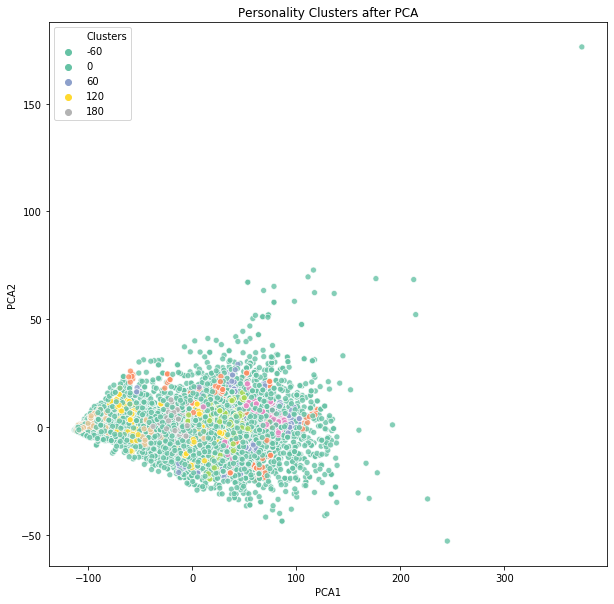

In [363]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Clusters', palette='Set2', alpha=0.8)
plt.title('Personality Clusters after PCA');